

<h1 align=center><font size = 5>Segmenting and Clustering Neighborhoods in Oslo, Norway</font></h1>

Oslo is the capital, economic and governmental centre of Norway. This make it attractive for professionals aiming to build carriere and building experience. 
Oslo was ranked number one in terms of quality of life among European large cities in the European Cities, but it’s a very expensive city as well. 
This notebook is dedicated to the Capstone project, aiming to help finding a suitable place to live in Oslo.


## Download all necessary libraries

In [ ]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!pip install folium
import folium 
import requests 
import matplotlib as mpl
import matplotlib.pyplot as plt
print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

## Data wrangling

Oslo has a total of 15 boroughs. 
This dataset exists for free in wikipedia: https://en.wikipedia.org/wiki/List_of_boroughs_of_Oslo#Borough_structure_1988%E2%80%932004.

In [ ]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_boroughs_of_Oslo#Borough_structure_1988%E2%80%932004')
df=df[0]
df

,Borough,Residents,Area,Number
0,Alna,49 801,"13,7 km2",12
1,Bjerke,33 422,"7,7 km2",9
2,Frogner,59 269,"8,3 km2",5
3,Gamle Oslo,58 671,"7,5 km2",1
4,Grorud,27 707,"8,2 km2",10
5,Grünerløkka,62 423,"4,8 km2",2
6,Nordre Aker,52 327,"13,6 km2",8
7,Nordstrand,52 459,"16,9 km2",14
8,Sagene,45 089,"3,1 km2",3
9,St. Hanshaugen,38 945,"3,6 km2",4


drop the columns which we don't need

In [ ]:
df.drop(df.columns[[1, 2, 3]], axis = 1, inplace = True) 
df = df.reindex(columns = df.columns.tolist())
df

,Borough
0,Alna
1,Bjerke
2,Frogner
3,Gamle Oslo
4,Grorud
5,Grünerløkka
6,Nordre Aker
7,Nordstrand
8,Sagene
9,St. Hanshaugen


In [ ]:
address = 'Oslo'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Oslo are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Oslo are 59.9133301, 10.7389701.


Add coordinates of boroughs to the dataset

In [ ]:
df1 = df.copy()
latlon = df1.Borough.apply(lambda addr: geolocator.geocode(addr))
df1["Latitude"] = [x.latitude for x in latlon]
df1["Longitude"] = [x.longitude for x in latlon]

In [ ]:
df1

,Borough,Latitude,Longitude
0,Alna,59.932417,10.835276
1,Bjerke,59.941395,10.829208
2,Frogner,59.922224,10.706649
3,Gamle Oslo,59.899237,10.734767
4,Grorud,59.961424,10.880549
5,Grünerløkka,59.925471,10.777421
6,Nordre Aker,59.953638,10.756412
7,Nordstrand,54.487378,8.865286
8,Sagene,59.938273,10.765849
9,St. Hanshaugen,59.927950,10.738958


Note that coordinates for Nordstrand are too much differ from the rest of Olso data. After checking the Google data there are: 59.8836 and 10.7857. This data will be fixed manually.

In [ ]:
df1.at[7,'Latitude'] = 59.8836
df1.at[7,'Longitude'] = 10.7857
df_oslo=df1
df_oslo

,Borough,Latitude,Longitude
0,Alna,59.932417,10.835276
1,Bjerke,59.941395,10.829208
2,Frogner,59.922224,10.706649
3,Gamle Oslo,59.899237,10.734767
4,Grorud,59.961424,10.880549
5,Grünerløkka,59.925471,10.777421
6,Nordre Aker,59.953638,10.756412
7,Nordstrand,59.883600,10.785700
8,Sagene,59.938273,10.765849
9,St. Hanshaugen,59.927950,10.738958


### Show Oslo boroughs on a map

In [ ]:
address = 'Oslo'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude


In [ ]:
map_oslo = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to map
for lat, lng, borough  in zip(df_oslo['Latitude'], df_oslo['Longitude'], df_oslo['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=20,
        popup=label,
        color='crimson',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_oslo)  
    
map_oslo

## Explore the boroughs with the Foursquare

Define Foursquare Credentials and Version

In [ ]:
CLIENT_ID = 'Z5XIJP4OATRNTZWDZV4Z0TGZ3EV24X3ITLAW4UVS2EGA1ZTM' # your Foursquare ID
CLIENT_SECRET = 'H3RXA0JXM54B1NDC3FOGQUY4UGF3EUT2Y2T5TMBYEZ3S05PF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Function that extracts the category of the venue

In [ ]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Function that get venues for the borough

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Iterate the boroughs in Oslo dataframe

In [ ]:
oslo_venues = getNearbyVenues(names=df_oslo['Borough'],latitudes=df_oslo['Latitude'],longitudes=df_oslo['Longitude'])
print(oslo_venues.shape)
oslo_venues.head()

(550, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alna,59.932417,10.835276,BROBEKK STORCASH AS,59.932201,10.831548,Grocery Store
1,Alna,59.932417,10.835276,Meny,59.936573,10.826252,Grocery Store
2,Alna,59.932417,10.835276,Serrano's,59.925757,10.846810,Spanish Restaurant
3,Alna,59.932417,10.835276,Stoff Og Stil,59.929213,10.846513,Arts & Crafts Store
4,Alna,59.932417,10.835276,Kiwi,59.937958,10.826332,Grocery Store


Check how many venues were returned for each borough

In [ ]:
oslo_venues.groupby('Borough').count()

,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Borough,,,,,,
Alna,26,26,26,26,26,26
Bjerke,12,12,12,12,12,12
Frogner,100,100,100,100,100,100
Gamle Oslo,25,25,25,25,25,25
Grorud,12,12,12,12,12,12
Grünerløkka,79,79,79,79,79,79
Nordre Aker,22,22,22,22,22,22
Nordstrand,9,9,9,9,9,9
Sagene,83,83,83,83,83,83


Let's find out how many unique categories can be curated from all the returned venues

In [ ]:
print('There are {} uniques categories.'.format(len(oslo_venues['Venue Category'].unique())))

There are 143 uniques categories.


## Analyze Each Borough

In [ ]:
oslo_onehot = pd.get_dummies(oslo_venues[['Venue Category']], prefix="", prefix_sep="")
oslo_onehot['Borough'] = oslo_venues['Borough'] 
fixed_columns = [oslo_onehot.columns[-1]] + list(oslo_onehot.columns[:-1])
oslo_onehot = oslo_onehot[fixed_columns]
oslo_onehot.shape


(550, 144)

Group rows by boroughs and by taking the mean of the frequency of occurrence of each category

In [ ]:
oslo_grouped = oslo_onehot.groupby('Borough').mean().reset_index()
oslo_grouped

,Borough,Advertising Agency,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bakery,Bar,Basketball Court,Bathing Area,Bay,Beach,Beer Bar,Beer Garden,Beer Store,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Café,Castle,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Community Center,Concert Hall,Convenience Store,Creperie,Deli / Bodega,Department Store,Dessert Shop,Diner,Disc Golf,Dog Run,Eastern European Restaurant,Electronics Store,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Flower Shop,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gas Station,Gastropub,Gluten-free Restaurant,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health Food Store,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Kids Store,Lake,Light Rail Station,Market,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Noodle House,Other Nightlife,Park,Performing Arts Venue,Pet Store,Pier,Pizza Place,Platform,Playground,Plaza,Pub,Public Art,Rafting,Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Ski Area,Smoothie Shop,Soccer Field,Soccer Stadium,Spanish Restaurant,Sporting Goods Shop,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Toy / Game Store,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop,Yoga Studio
0,Alna,0.000000,0.000000,0.038462,0.000000,0.000000,0.038462,0.038462,0.00,0.038462,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.038462,0.000000,0.000000,0.000000,0.000000,0.115385,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.115385,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.115385,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.038462,0.00,0.00,0.000000,0.00,0.00,0.00,0.038462,0.000000,0.000000,0.038462,0.115385,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.076923,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.038462,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.038462,0.00,0.038462,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
1,Bjerke,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.166667,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.083333,0.00,0.083333,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.250000,0.000000,0.083333,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.083333,0.00,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.083333,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0000

Confirm the new size

In [ ]:
oslo_grouped.shape

(15, 144)

Print each borough along with the top 5 most common venues

In [ ]:
num_top_venues = 5

for hood in oslo_grouped['Borough']:
    print("----"+hood+"----")
    temp = oslo_grouped[oslo_grouped['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alna----
                    venue  freq
0           Metro Station  0.12
1           Grocery Store  0.12
2             Bus Station  0.12
3  Furniture / Home Store  0.12
4               Pet Store  0.08


----Bjerke----
                  venue  freq
0         Grocery Store  0.25
1                  Café  0.17
2  Gym / Fitness Center  0.08
3           Supermarket  0.08
4  Fast Food Restaurant  0.08


----Frogner----
                     venue  freq
0                     Café  0.07
1                   Bakery  0.07
2              Coffee Shop  0.06
3        Indian Restaurant  0.04
4  Scandinavian Restaurant  0.04


----Gamle Oslo----
                     venue  freq
0            Boat or Ferry  0.32
1                     Pier  0.08
2  Scandinavian Restaurant  0.08
3                   Castle  0.08
4           History Museum  0.04


----Grorud----
           venue  freq
0    Supermarket  0.17
1  Metro Station  0.17
2  Grocery Store  0.17
3            Gym  0.08
4      Wine Shop  0.08


----Gr

Function to sort the venues in descending order.

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each borough

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
boroughs_venues_sorted = pd.DataFrame(columns=columns)
boroughs_venues_sorted['Borough'] = oslo_grouped['Borough']

for ind in np.arange(oslo_grouped.shape[0]):
    boroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(oslo_grouped.iloc[ind, :], num_top_venues)

# add average price for square meter for each borough 
# boroughs_venues_sorted.insert(1, 'Price for M2', df_oslo['Price'])

boroughs_venues_sorted

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alna,Metro Station,Grocery Store,Furniture / Home Store,Bus Station,Pet Store,Bakery,Market,Bookstore,Kids Store,Electronics Store
1,Bjerke,Grocery Store,Café,Pizza Place,Supermarket,Metro Station,Farm,Fast Food Restaurant,Hotel,Gym / Fitness Center,Deli / Bodega
2,Frogner,Café,Bakery,Coffee Shop,Indian Restaurant,Scandinavian Restaurant,Hotel,Pizza Place,Wine Shop,Burger Joint,Pub
3,Gamle Oslo,Boat or Ferry,Pier,Castle,Scandinavian Restaurant,History Museum,Italian Restaurant,Market,Café,Seafood Restaurant,Beach
4,Grorud,Grocery Store,Metro Station,Supermarket,Wine Shop,Asian Restaurant,Athletics & Sports,Gym,Pizza Place,Soccer Field,Yoga Studio
5,Grünerløkka,Grocery Store,Café,Gym / Fitness Center,Sushi Restaurant,Bar,Park,Bakery,Coffee Shop,Botanical Garden,Asian Restaurant
6,Nordre Aker,Gym,Grocery Store,Bus Stop,Shopping Mall,Bakery,Metro Station,Advertising Agency,Theme Park,Coffee Shop,Café
7,Nordstrand,Grocery Store,Stadium,Pet Store,Metro Station,Light Rail Station,Soccer Stadium,Bakery,Soccer Field,Department Store,Deli / Bodega
8,Sagene,Café,Sushi Restaurant,Grocery Store,Coffee Shop,Park,Bakery,Pizza Place,Bar,Brewery,Indian Restaurant
9,St. Hanshaugen,Bakery,Café,Coffee Shop,Scandinavian Restaurant,Park,Pizza Place,Indian Restaurant,Asian Restaurant,Gym / Fitness Center,Bar


<a id='item4'></a>

## Cluster Boroughs

Run *k*-means to cluster the boroughs into 5 clusters.

In [1]:
# set number of clusters
ks = 5

oslo_grouped_clustering = oslo_grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=ks, random_state=0).fit(oslo_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

NameError: ignored

In [ ]:
lt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [ ]:
boroughs_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
boroughs_venues_sorted

,Cluster Labels,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Alna,Metro Station,Grocery Store,Furniture / Home Store,Bus Station,Pet Store,Bakery,Market,Bookstore,Kids Store,Electronics Store
1,1,Bjerke,Grocery Store,Café,Pizza Place,Supermarket,Metro Station,Farm,Fast Food Restaurant,Hotel,Gym / Fitness Center,Deli / Bodega
2,1,Frogner,Café,Bakery,Coffee Shop,Indian Restaurant,Scandinavian Restaurant,Hotel,Pizza Place,Wine Shop,Burger Joint,Pub
3,2,Gamle Oslo,Boat or Ferry,Pier,Castle,Scandinavian Restaurant,History Museum,Italian Restaurant,Market,Café,Seafood Restaurant,Beach
4,3,Grorud,Grocery Store,Metro Station,Supermarket,Wine Shop,Asian Restaurant,Athletics & Sports,Gym,Pizza Place,Soccer Field,Yoga Studio
5,1,Grünerløkka,Grocery Store,Café,Gym / Fitness Center,Sushi Restaurant,Bar,Park,Bakery,Coffee Shop,Botanical Garden,Asian Restaurant
6,1,Nordre Aker,Gym,Grocery Store,Bus Stop,Shopping Mall,Bakery,Metro Station,Advertising Agency,Theme Park,Coffee Shop,Café
7,0,Nordstrand,Grocery Store,Stadium,Pet Store,Metro Station,Light Rail Station,Soccer Stadium,Bakery,Soccer Field,Department Store,Deli / Bodega
8,1,Sagene,Café,Sushi Restaurant,Grocery Store,Coffee Shop,Park,Bakery,Pizza Place,Bar,Brewery,Indian Restaurant
9,1,St. Hanshaugen,Bakery,Café,Coffee Shop,Scandinavian Restaurant,Park,Pizza Place,Indian Restaurant,Asian Restaurant,Gym / Fitness Center,Bar


Let's create a new dataframe that includes the cluster as well as the top 10 venues for each borough.

In [ ]:
oslo_merged = df_oslo

oslo_merged = oslo_merged.join(boroughs_venues_sorted.set_index('Borough'), on='Borough')
oslo_merged = oslo_merged.dropna()
oslo_merged.reset_index(drop = True, inplace = True)

oslo_merged

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alna,59.932417,10.835276,1,Metro Station,Grocery Store,Furniture / Home Store,Bus Station,Pet Store,Bakery,Market,Bookstore,Kids Store,Electronics Store
1,Bjerke,59.941395,10.829208,1,Grocery Store,Café,Pizza Place,Supermarket,Metro Station,Farm,Fast Food Restaurant,Hotel,Gym / Fitness Center,Deli / Bodega
2,Frogner,59.922224,10.706649,1,Café,Bakery,Coffee Shop,Indian Restaurant,Scandinavian Restaurant,Hotel,Pizza Place,Wine Shop,Burger Joint,Pub
3,Gamle Oslo,59.899237,10.734767,2,Boat or Ferry,Pier,Castle,Scandinavian Restaurant,History Museum,Italian Restaurant,Market,Café,Seafood Restaurant,Beach
4,Grorud,59.961424,10.880549,3,Grocery Store,Metro Station,Supermarket,Wine Shop,Asian Restaurant,Athletics & Sports,Gym,Pizza Place,Soccer Field,Yoga Studio
5,Grünerløkka,59.925471,10.777421,1,Grocery Store,Café,Gym / Fitness Center,Sushi Restaurant,Bar,Park,Bakery,Coffee Shop,Botanical Garden,Asian Restaurant
6,Nordre Aker,59.953638,10.756412,1,Gym,Grocery Store,Bus Stop,Shopping Mall,Bakery,Metro Station,Advertising Agency,Theme Park,Coffee Shop,Café
7,Nordstrand,59.883600,10.785700,0,Grocery Store,Stadium,Pet Store,Metro Station,Light Rail Station,Soccer Stadium,Bakery,Soccer Field,Department Store,Deli / Bodega
8,Sagene,59.938273,10.765849,1,Café,Sushi Restaurant,Grocery Store,Coffee Shop,Park,Bakery,Pizza Place,Bar,Brewery,Indian Restaurant
9,St. Hanshaugen,59.927950,10.738958,1,Bakery,Café,Coffee Shop,Scandinavian Restaurant,Park,Pizza Place,Indian Restaurant,Asian Restaurant,Gym / Fitness Center,Bar


In [ ]:
oslo_merged.dtypes

Borough                    object
Latitude                  float64
Longitude                 float64
Cluster Labels              int32
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

Visualize the resulting clusters

In [ ]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.gist_rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(oslo_merged['Latitude'], oslo_merged['Longitude'], oslo_merged['Borough'], oslo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=30,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.3).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [ ]:
oslo_merged.loc[oslo_merged['Cluster Labels'] == 0, oslo_merged.columns[[0] + list(range(4, oslo_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Nordstrand,Grocery Store,Stadium,Pet Store,Metro Station,Light Rail Station,Soccer Stadium,Bakery,Soccer Field,Department Store,Deli / Bodega
10,Stovner,Grocery Store,Department Store,Ski Area,Video Game Store,Athletics & Sports,Golf Course,Shopping Mall,Gas Station,Diner,Electronics Store
13,Vestre Aker,Grocery Store,Ski Area,Metro Station,Soccer Field,Restaurant,Café,Scandinavian Restaurant,Theme Park Ride / Attraction,Disc Golf,Museum


#### Cluster 2

In [ ]:
oslo_merged.loc[oslo_merged['Cluster Labels'] == 1, oslo_merged.columns[[0] + list(range(4, oslo_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alna,Metro Station,Grocery Store,Furniture / Home Store,Bus Station,Pet Store,Bakery,Market,Bookstore,Kids Store,Electronics Store
1,Bjerke,Grocery Store,Café,Pizza Place,Supermarket,Metro Station,Farm,Fast Food Restaurant,Hotel,Gym / Fitness Center,Deli / Bodega
2,Frogner,Café,Bakery,Coffee Shop,Indian Restaurant,Scandinavian Restaurant,Hotel,Pizza Place,Wine Shop,Burger Joint,Pub
5,Grünerløkka,Grocery Store,Café,Gym / Fitness Center,Sushi Restaurant,Bar,Park,Bakery,Coffee Shop,Botanical Garden,Asian Restaurant
6,Nordre Aker,Gym,Grocery Store,Bus Stop,Shopping Mall,Bakery,Metro Station,Advertising Agency,Theme Park,Coffee Shop,Café
8,Sagene,Café,Sushi Restaurant,Grocery Store,Coffee Shop,Park,Bakery,Pizza Place,Bar,Brewery,Indian Restaurant
9,St. Hanshaugen,Bakery,Café,Coffee Shop,Scandinavian Restaurant,Park,Pizza Place,Indian Restaurant,Asian Restaurant,Gym / Fitness Center,Bar
12,Ullern,Bus Station,Market,Metro Station,Italian Restaurant,Rafting,Electronics Store,Burger Joint,Light Rail Station,Flower Shop,Coffee Shop


#### Cluster 3

In [ ]:
oslo_merged.loc[oslo_merged['Cluster Labels'] == 2, oslo_merged.columns[[0] + list(range(4, oslo_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Gamle Oslo,Boat or Ferry,Pier,Castle,Scandinavian Restaurant,History Museum,Italian Restaurant,Market,Café,Seafood Restaurant,Beach


#### Cluster 4

In [ ]:
oslo_merged.loc[oslo_merged['Cluster Labels'] == 3, oslo_merged.columns[[0] + list(range(4, oslo_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Grorud,Grocery Store,Metro Station,Supermarket,Wine Shop,Asian Restaurant,Athletics & Sports,Gym,Pizza Place,Soccer Field,Yoga Studio
14,Østensjø,Metro Station,Athletics & Sports,Shopping Mall,Pizza Place,Basketball Court,Skating Rink,Burger Joint,Lake,Supermarket,Soccer Field


#### Cluster 5

In [ ]:
oslo_merged.loc[oslo_merged['Cluster Labels'] == 4, oslo_merged.columns[[0] + list(range(4, oslo_merged.shape[1]))]]

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Søndre Nordstrand,Grocery Store,Shopping Mall,Stadium,Athletics & Sports,Train Station,Fast Food Restaurant,Business Service,Disc Golf,Farm,Falafel Restaurant


Add price information to consideration

In [ ]:
oslo_merged.head()

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alna,59.932417,10.835276,1,Metro Station,Grocery Store,Furniture / Home Store,Bus Station,Pet Store,Bakery,Market,Bookstore,Kids Store,Electronics Store
1,Bjerke,59.941395,10.829208,1,Grocery Store,Café,Pizza Place,Supermarket,Metro Station,Farm,Fast Food Restaurant,Hotel,Gym / Fitness Center,Deli / Bodega
2,Frogner,59.922224,10.706649,1,Café,Bakery,Coffee Shop,Indian Restaurant,Scandinavian Restaurant,Hotel,Pizza Place,Wine Shop,Burger Joint,Pub
3,Gamle Oslo,59.899237,10.734767,2,Boat or Ferry,Pier,Castle,Scandinavian Restaurant,History Museum,Italian Restaurant,Market,Café,Seafood Restaurant,Beach
4,Grorud,59.961424,10.880549,3,Grocery Store,Metro Station,Supermarket,Wine Shop,Asian Restaurant,Athletics & Sports,Gym,Pizza Place,Soccer Field,Yoga Studio


In [ ]:
prices_oslo = oslo_merged[['Borough', 'Cluster Labels']].copy()


Add average price for square meter to the dataframe. Read the prices from csv file which was placed to my github repository and merge it to the dataframe.

In [ ]:
url = 'https://raw.githubusercontent.com/Julechka/Coursera_Capstone/master/Capstone-oslo-price.csv'
df_csv = pd.read_csv(url)
prices_oslo = pd.merge(prices_oslo, df_csv, on=['Borough'])
prices_oslo

,Borough,Cluster Labels,Price
0,Alna,1,49042
1,Bjerke,1,58834
2,Frogner,1,87923
3,Gamle Oslo,2,74605
4,Grorud,3,49224
5,Grünerløkka,1,76413
6,Nordre Aker,1,78073
7,Nordstrand,0,60350
8,Sagene,1,80766
9,St. Hanshaugen,1,81649


Sort boroughs on price column

In [ ]:
prices_oslo = prices_oslo.sort_values(by=['Price'])
prices_oslo

,Borough,Cluster Labels,Price
11,Søndre Nordstrand,4,41235
10,Stovner,0,42394
0,Alna,1,49042
4,Grorud,3,49224
14,Østensjø,3,56556
1,Bjerke,1,58834
7,Nordstrand,0,60350
13,Vestre Aker,0,67186
12,Ullern,1,74109
3,Gamle Oslo,2,74605


Display the prices in a horizontal plot

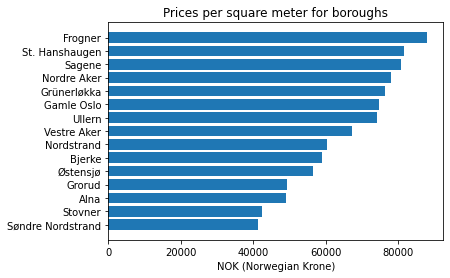

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
y_pos = np.arange(len(prices_oslo['Borough']))
plt.barh(y_pos, prices_oslo['Price'], align='center', alpha=1)
plt.yticks(y_pos, prices_oslo['Borough'])
plt.xlabel('NOK (Norwegian Krone)')
plt.title('Prices per square meter for boroughs')
plt.show()

Add Cluster labels to the plot

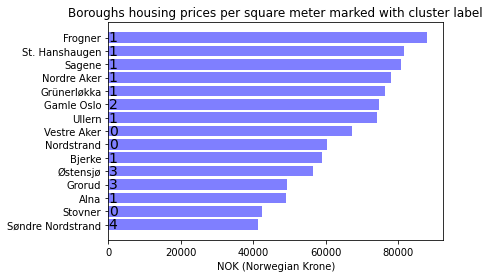

In [ ]:
y = prices_oslo['Price']
y1 = prices_oslo['Cluster Labels']
fig, ax = plt.subplots()
# ax.barh(y.index, y, height=0.75)
ax.barh(y_pos, prices_oslo['Price'], align='center', color='blue', alpha=0.5)
y_pos = np.arange(len(prices_oslo['Borough']))
plt.yticks(y_pos, prices_oslo['Borough'])
plt.xlabel('NOK (Norwegian Krone)')
plt.title('Boroughs housing prices per square meter marked with cluster label')
for i, v in enumerate(y1):
    ax.text(v + 100, i, str(v), color='black', fontsize=14, ha='left', va='center')
plt.show()

Visualize it grouping by clusters

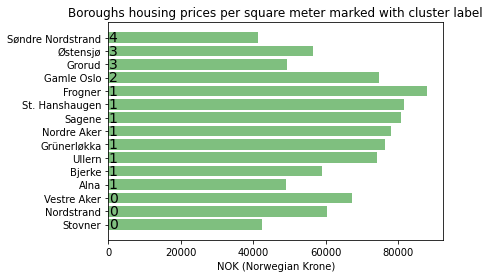

In [ ]:
cl_oslo = prices_oslo.sort_values(by=['Cluster Labels'])
y = cl_oslo['Price']
y2 = cl_oslo['Cluster Labels']
fig, ax = plt.subplots()
# ax.barh(y.index, y, height=0.75)
ax.barh(y_pos, y, align='center', color='green', alpha=0.5)
y_pos = np.arange(len(cl_oslo['Borough']))
plt.yticks(y_pos, cl_oslo['Borough'])
plt.xlabel('NOK (Norwegian Krone)')
plt.title('Boroughs housing prices per square meter marked with cluster label')
for i, v in enumerate(y2):
    ax.text(v + 100, i, str(v), color='black', fontsize=14, ha='left', va='center')
plt.show()